# Hyperparameter analysis in Manna model

The purpose of this notebook is to find out the effect of hyperparameter $a$ on the quality of predictions. Obviously, the larger hyperparameter $a$ means the larger the memory in AR(1) process. 

Let's calculate time when the forecast will contribute less than 1 to the decision variable:

$$ a^n \cdot s < 1$$

Under the assumption $a(L) = e^{-\frac{1}{T(L)}}$:

$$ e^{-\frac{n}{T(L)}} < 1 $$

Consequently:

$$ n > \ln s \cdot T(L) $$

In [1]:
%load_ext autoreload
%autoreload 2

import os
os.chdir("../")

import sys
sys.path.insert(1, 'src/')

In [4]:
# import abel_heap
# import numpy as np

# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np
# import pandas as pd
from utils import *

plt.rcParams["figure.dpi"] = 200
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams['font.size'] = 36
plt.rcParams['axes.labelpad'] = 20
plt.rcParams['axes.titlepad'] = 30
TICKS_MAJOR = 6
TICKS_MINOR = 4.5
plt.rcParams['xtick.minor.size'] = TICKS_MINOR
plt.rcParams['xtick.major.size'] = TICKS_MAJOR
plt.rcParams['ytick.minor.size'] = TICKS_MINOR
plt.rcParams['ytick.major.size'] = TICKS_MAJOR

## Scaling

By the fixed $p$ and $\gamma$:

$$ \eta = p \cdot L^{\gamma} $$

Predict probability of:

$$ s_i > \eta $$

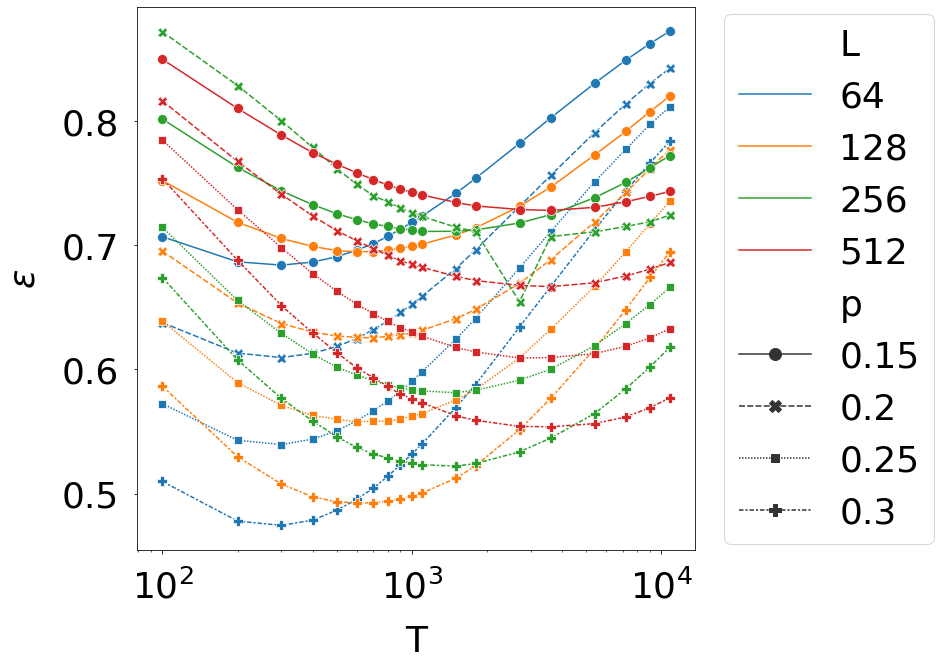

In [3]:
gamma = 2.55

PERCENTS_ETA = [0.15, 0.2, 0.25, 0.30]
LS = [64, 128, 256, 512]
TS = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1500, 1800, 1800 * 3 // 2, 1800*2, 1800*3, 1800*4, 1800*5, 1800*6]

auc_curve = calculate_roc_curve_gamma(gamma, PERCENTS_ETA, LS, TS, "rand", njobs=7)
plot_global_auc_curves(auc_curve, gamma)

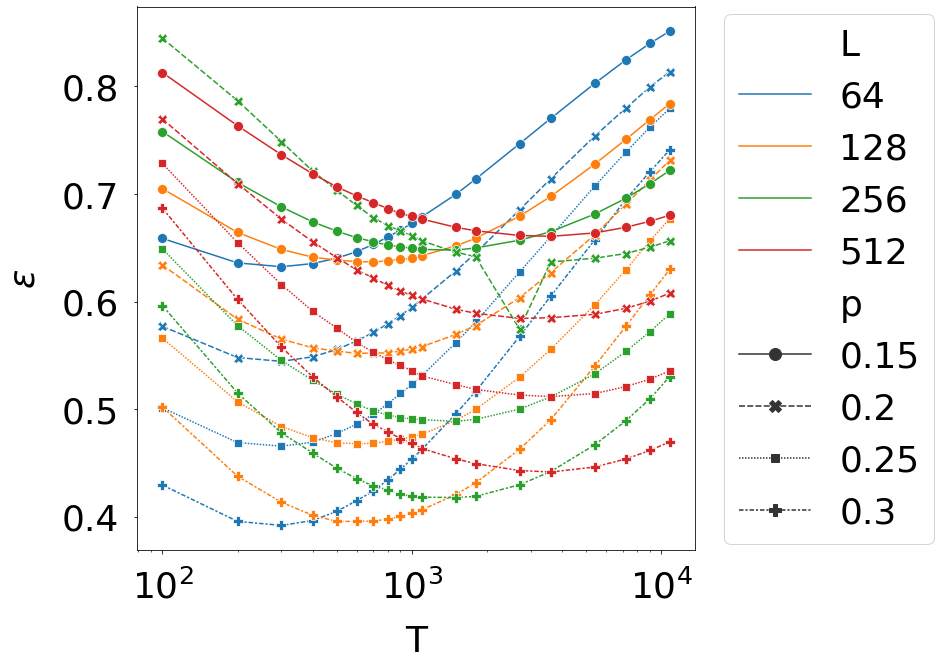

In [4]:
gamma = 2.6

auc_curve = calculate_roc_curve_gamma(gamma, PERCENTS_ETA, LS, TS, "rand", njobs=7)
plot_global_auc_curves(auc_curve, gamma)

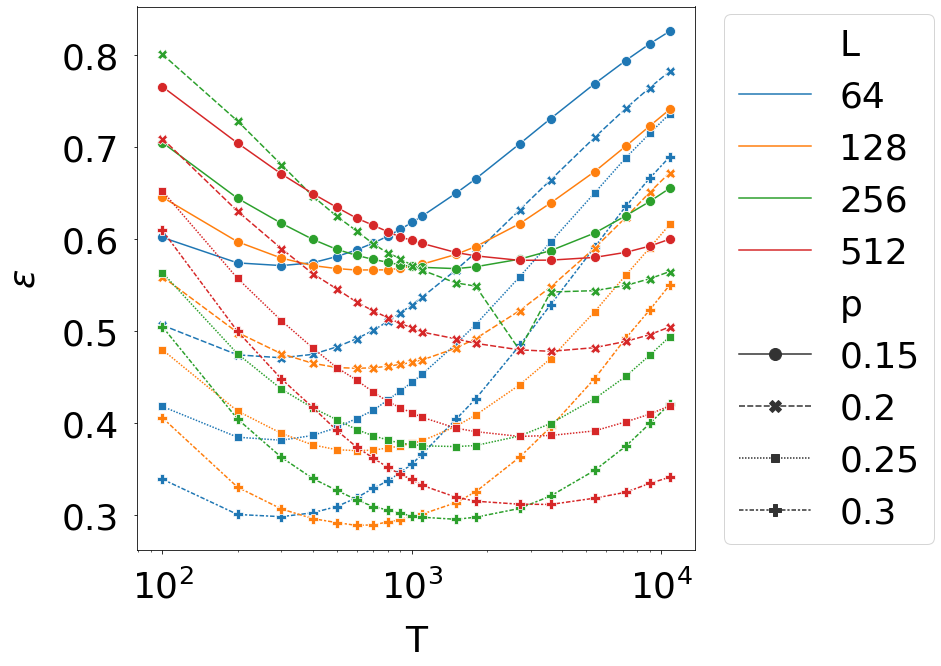

In [5]:
gamma = 2.65

auc_curve = calculate_roc_curve_gamma(gamma, PERCENTS_ETA, LS, TS, "rand", njobs=7)
plot_global_auc_curves(auc_curve, gamma)

In [ ]:
gamma = 2.67

PERCENTS_ETA = [0.15, 0.2, 0.25, 0.30]
LS = [64, 128, 256, 512]
TS = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1500, 1800, 1800 * 3 // 2, 1800*2, 1800*3, 1800*4, 1800*5, 1800*6]
PERCENTS_ETA_EXTENDED = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]

auc_curve = calculate_roc_curve_gamma(gamma, PERCENTS_ETA, LS, TS, "rand", njobs=7, use_cache=False)

rename_p = "b"
auc_curve[rename_p] = auc_curve["p"]

sns.lineplot(data=auc_curve, x="T", y="eps", hue="L", style=rename_p, markers=True, palette="tab10", markersize=7)

TS = [300, int(300 * 2.25), int(300 * 2.25**2), int(300*2.25**3)]
roc_curve = calculate_roc_curve_gamma(gamma, PERCENTS_ETA, LS, TS, "rand", njobs=7, grid=False)
opt_metric = roc_curve.copy().reset_index()
opt_metric["p"] = opt_metric["p"].astype(float)
event_rate = calculate_event_rate(gamma, PERCENTS_ETA_EXTENDED, LS, "rand")
opt_metric = pd.merge(opt_metric, event_rate, on=["L", "p", "model"], how="left")

for i, row in opt_metric.iterrows():
    plt.plot(row["T"], row["eps"], "r^", label="Optimal T" if i == 0 else "", markersize=15, color="tab:purple")

str_gamma = "{" + f"{gamma:.3}" + "}"
plt.xlabel("parameter T")
plt.ylabel("Sum of errors, $\epsilon$")
plt.xscale("log")
plt.plot()
plt.legend(bbox_to_anchor=(1.03,1.03), loc="upper left", markerscale=2)
plt.show()

In [24]:
auc_curve = calculate_roc_curve_gamma_min_event_rate(gamma, PERCENTS_ETA, LS, TS, "rand", min_event_rate=0, njobs=7, grid=False)

In [25]:
auc_curve[["L", "p", "event_rate"]]

,L,p,event_rate
0,64,0.15,NaN
1,64,0.20,NaN
2,64,0.25,NaN
3,128,0.15,NaN
4,128,0.20,NaN
5,128,0.25,NaN
6,128,0.30,NaN
7,256,0.15,NaN
8,256,0.20,NaN
9,256,0.25,NaN


In [28]:
event_rates = calculate_event_rate(gamma, PERCENTS_ETA, LS, "rand")

In [34]:
event_rates[["p", "L", "event_rate"]].sort_values(["p"])

,p,L,event_rate
0,0.15,64,7.322800e-04
4,0.15,128,4.120600e-04
8,0.15,256,2.398000e-04
12,0.15,512,1.423400e-04
1,0.20,64,1.713800e-04
5,0.20,128,9.196000e-05
9,0.20,256,5.574000e-05
13,0.20,512,3.348000e-05
2,0.25,64,3.108000e-05
6,0.25,128,1.678000e-05


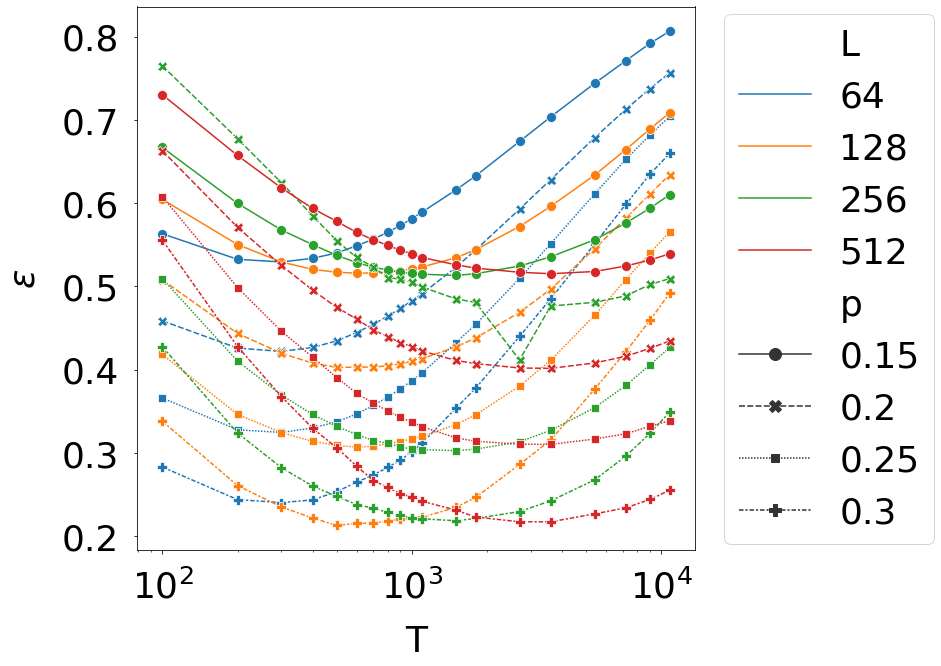

In [9]:
gamma = 2.68

auc_curve = calculate_roc_curve_gamma(gamma, PERCENTS_ETA, LS, TS, "rand", njobs=7)
plot_global_auc_curves(auc_curve, gamma)

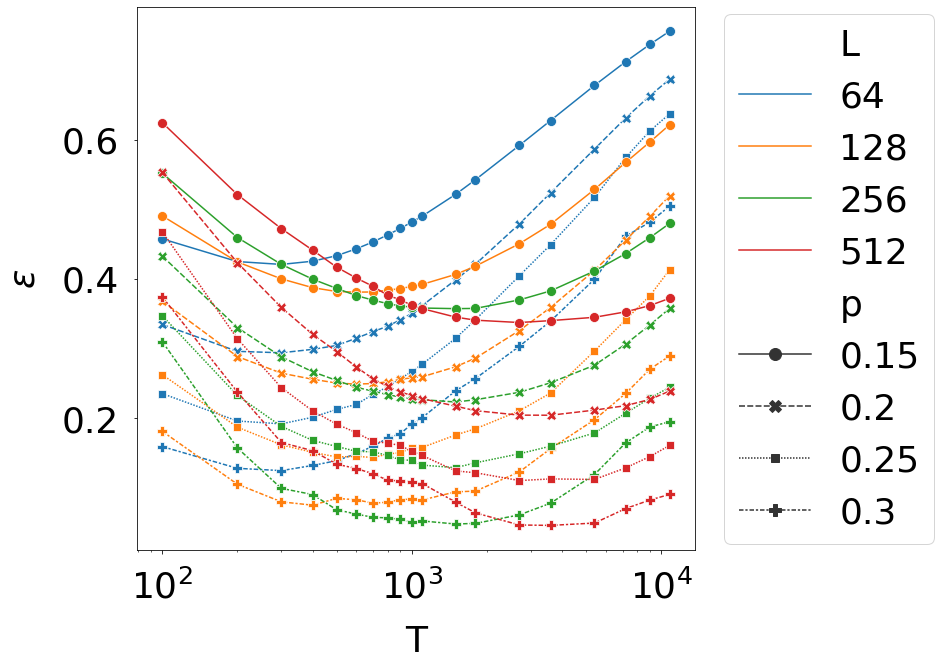

In [11]:
gamma = 2.75

auc_curve = calculate_roc_curve_gamma(gamma, PERCENTS_ETA, LS, TS, "rand", njobs=7)
plot_global_auc_curves(auc_curve, gamma)

## Find an optimal T(L)

Let's see on the optimal $T(L)$ for different $\gamma$

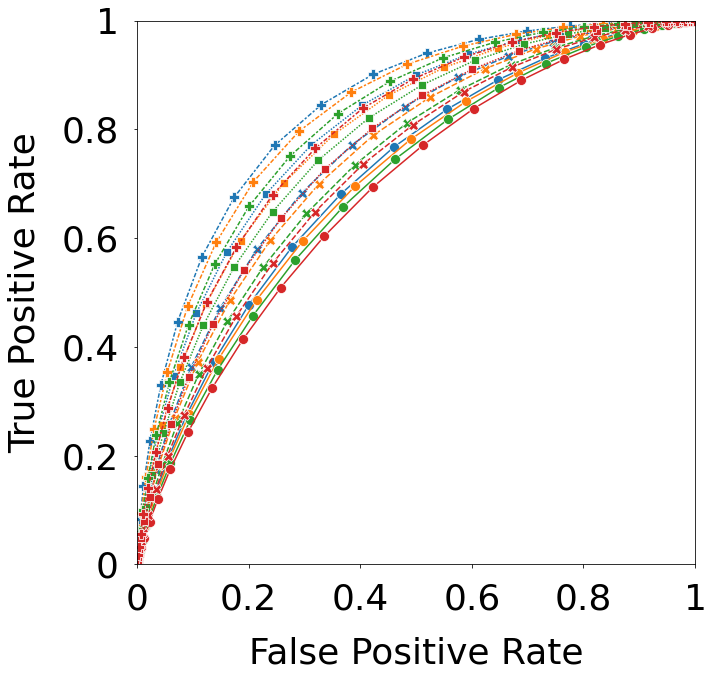

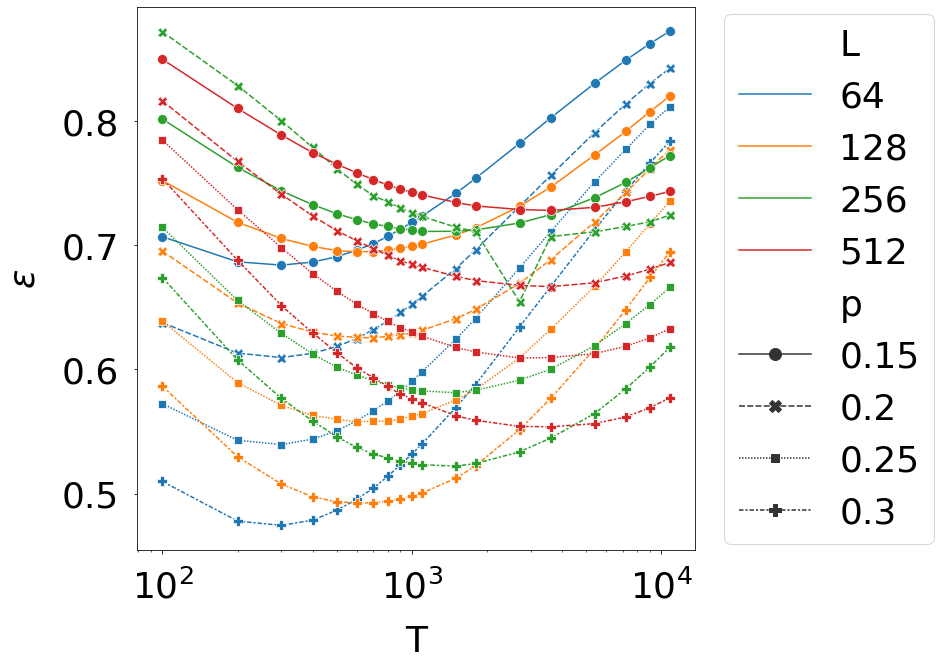

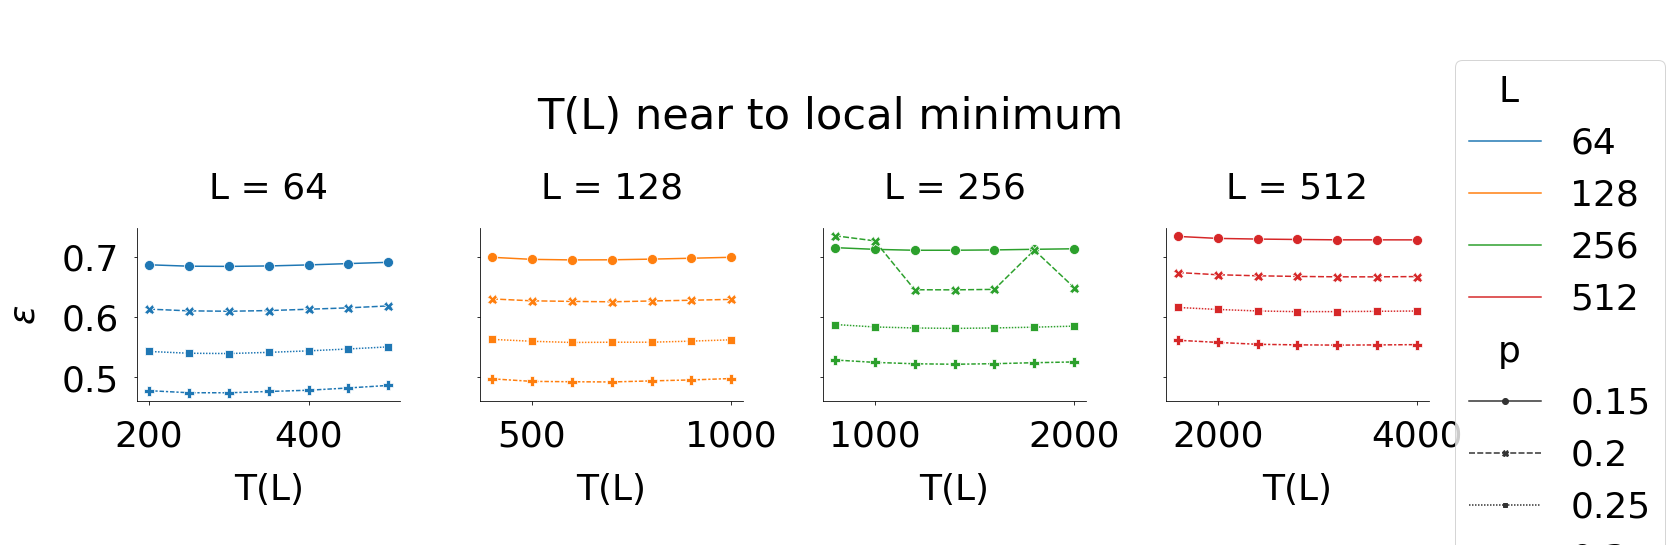

In [15]:
gamma = 2.55
t_scaling = 2

LS = [64, 128, 256, 512]
PERCENTS_ETA = [0.15, 0.2, 0.25, 0.30]
TS_local = [200, 250, 300, 350, 400, 450, 500]
TS_global = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1500, 1800, 1800 * 3 // 2, 1800*2, 1800*3, 1800*4, 1800*5, 1800*6]

plot_local_global(gamma, t_scaling, LS, PERCENTS_ETA, TS_local, TS_global, "rand")

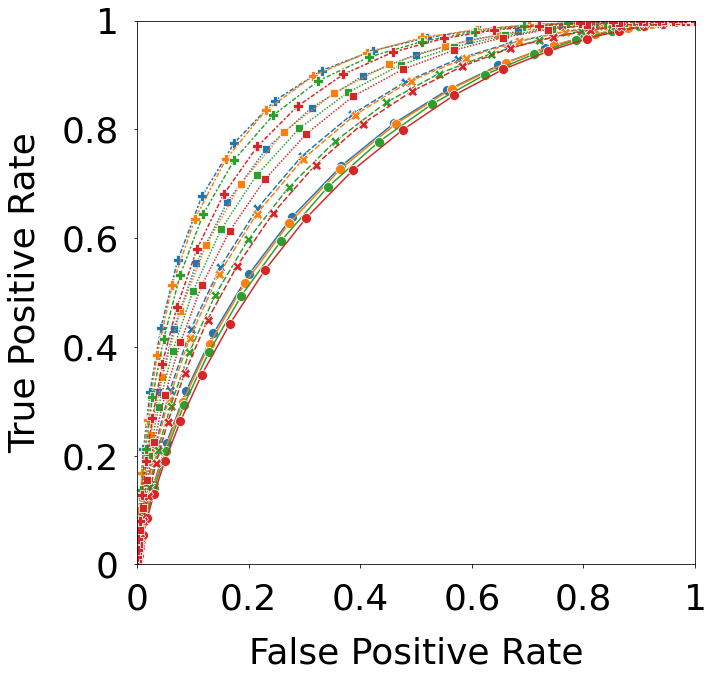

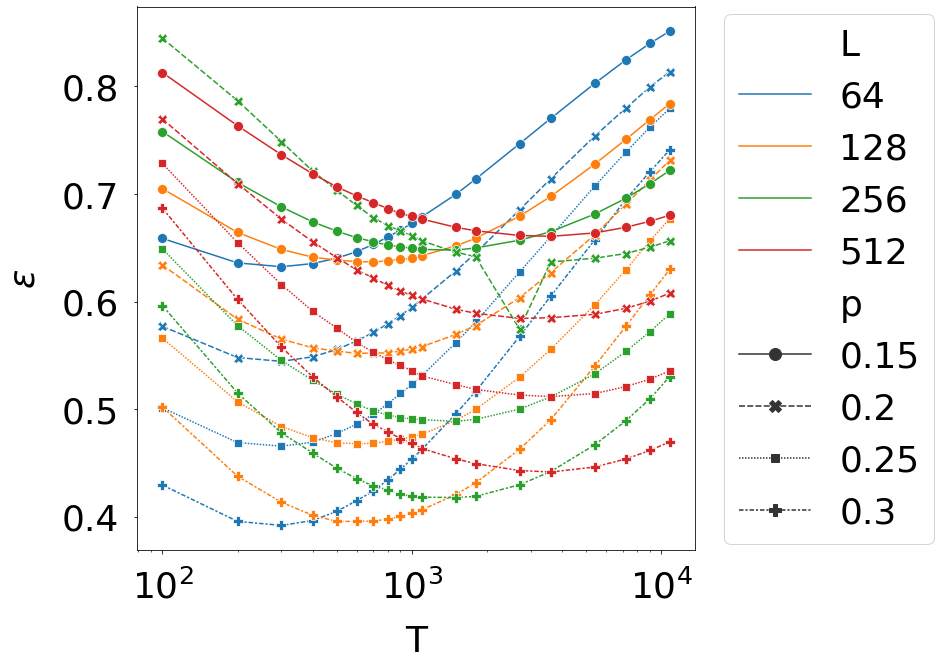

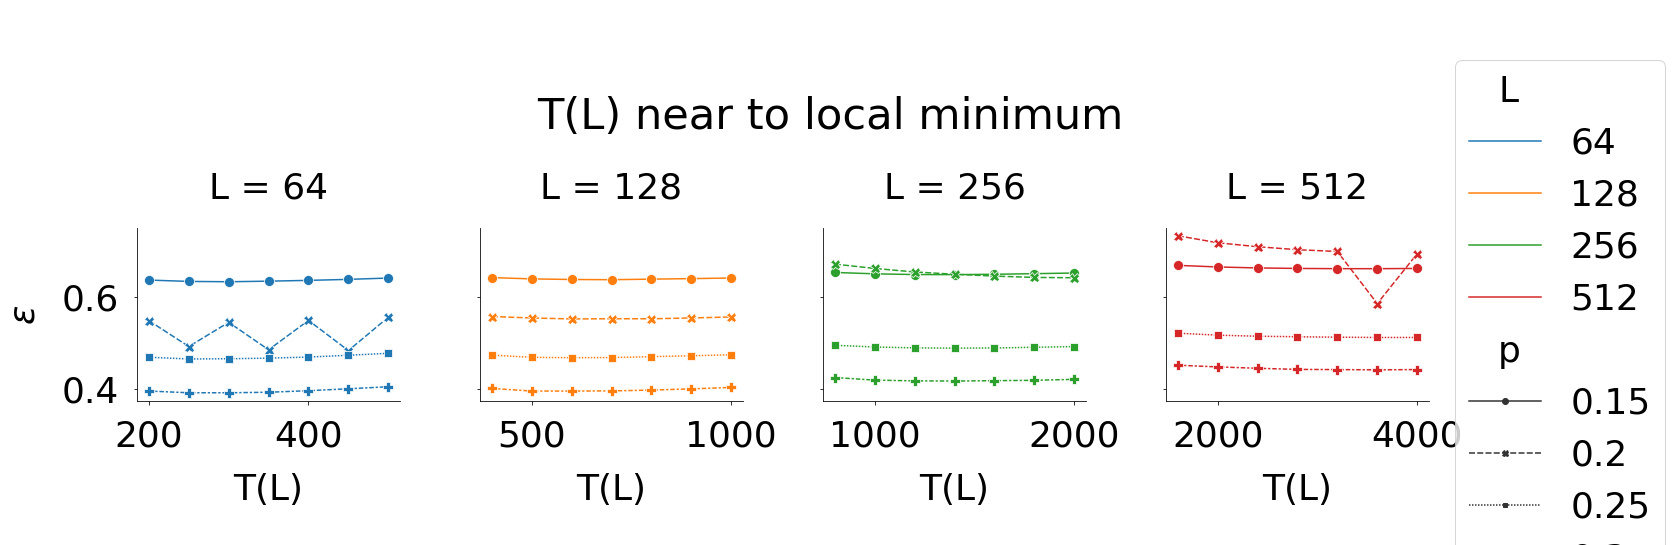

In [16]:
gamma = 2.60
t_scaling = 2

LS = [64, 128, 256, 512]
PERCENTS_ETA = [0.15, 0.2, 0.25, 0.30]
TS_local = [200, 250, 300, 350, 400, 450, 500]
TS_global = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1500, 1800, 1800 * 3 // 2, 1800*2, 1800*3, 1800*4, 1800*5, 1800*6]

plot_local_global(gamma, t_scaling, LS, PERCENTS_ETA, TS_local, TS_global, "rand")

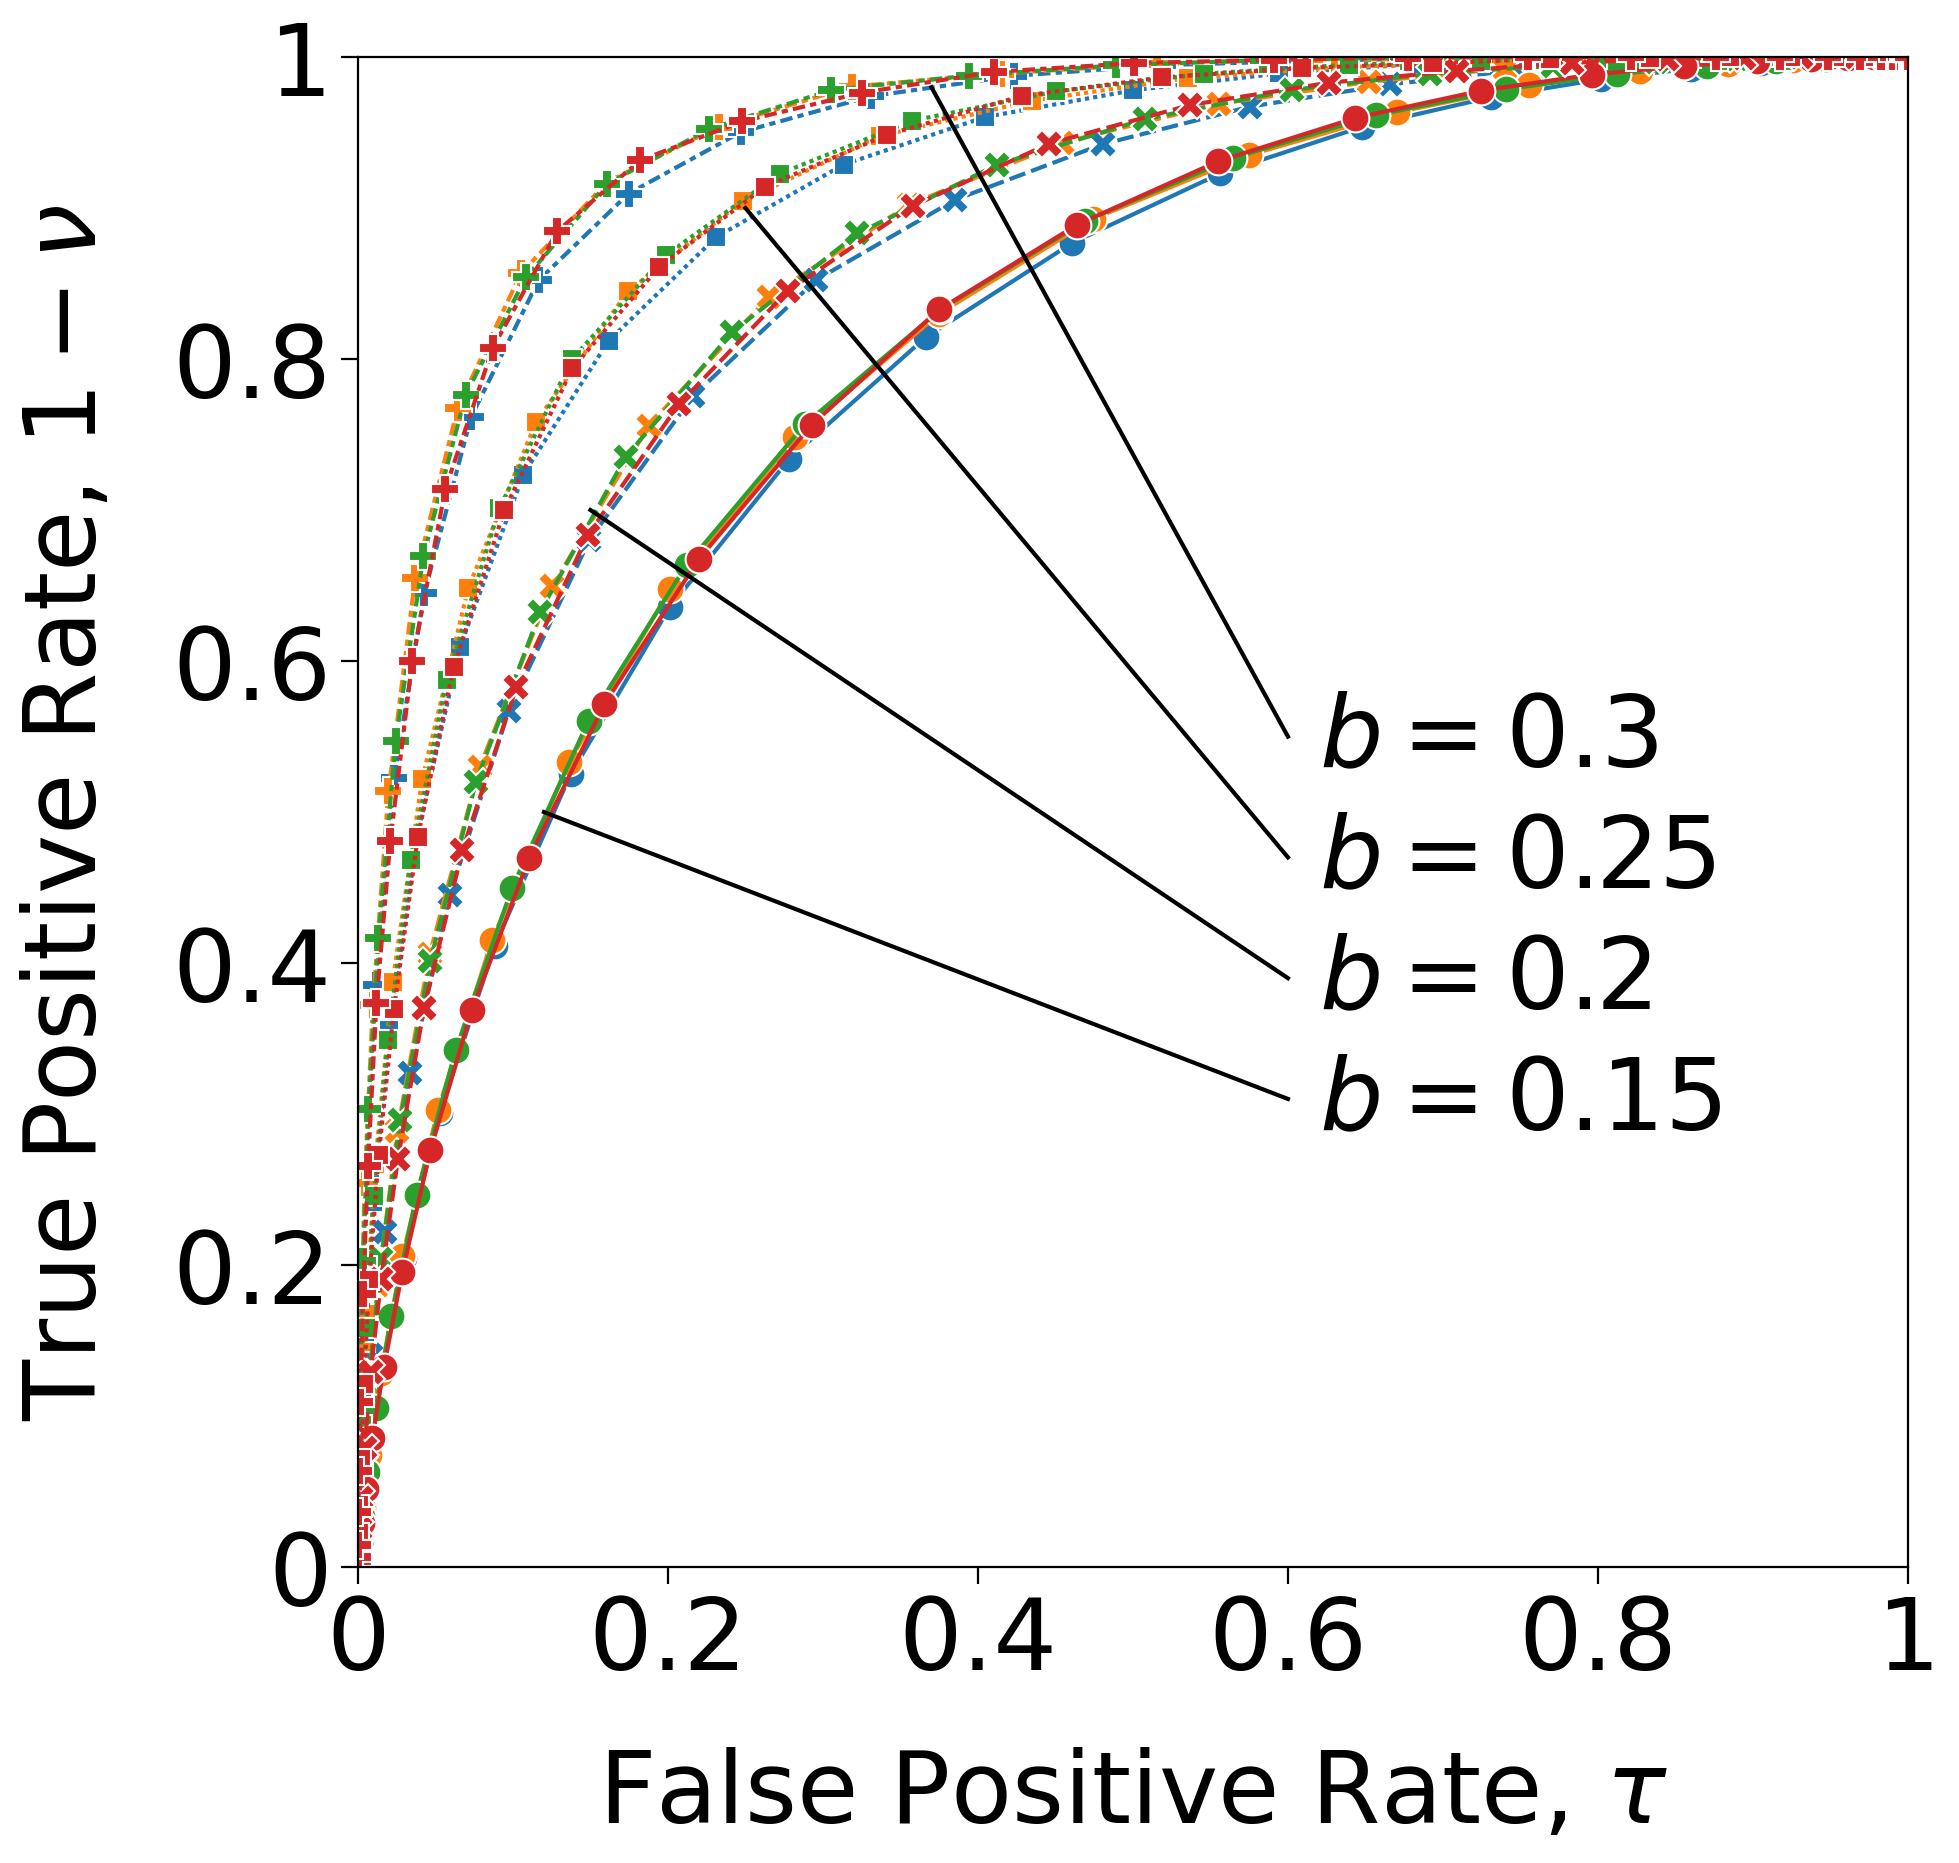

In [35]:
gamma = 2.67

#plot_local_global(gamma, t_scaling, LS, PERCENTS_ETA, TS_local, TS_global, "rand")
PERCENTS_ETA = [0.15, 0.2, 0.25, 0.30]
LS = [64, 128, 256, 512]
TS = [300, int(300 * 2.25), int(300 * 2.25**2), int(300*2.25**3)]

roc_curve = calculate_roc_curve_gamma(gamma, PERCENTS_ETA, LS, TS, "rand", njobs=7, grid=False)
opt_metric = roc_curve.copy().reset_index()
opt_metric["p"] = opt_metric["p"].astype(float)
# event_rate = calculate_event_rate(gamma, PERCENTS_ETA_EXTENDED, LS, "rand")
# opt_metric = pd.merge(opt_metric, event_rate, on=["L", "p", "model"], how="left")

plot_auc_curve(opt_metric)

plot_annotation([0.37, 0.98], [0.6, 0.55], r"$b = 0.3$")
plot_annotation([0.25, 0.9], [0.6, 0.47], r"$b = 0.25$")
plot_annotation([0.15, 0.7], [0.6, 0.39], r"$b = 0.2$")
plot_annotation([0.12, 0.5], [0.6, 0.31], r"$b = 0.15$")

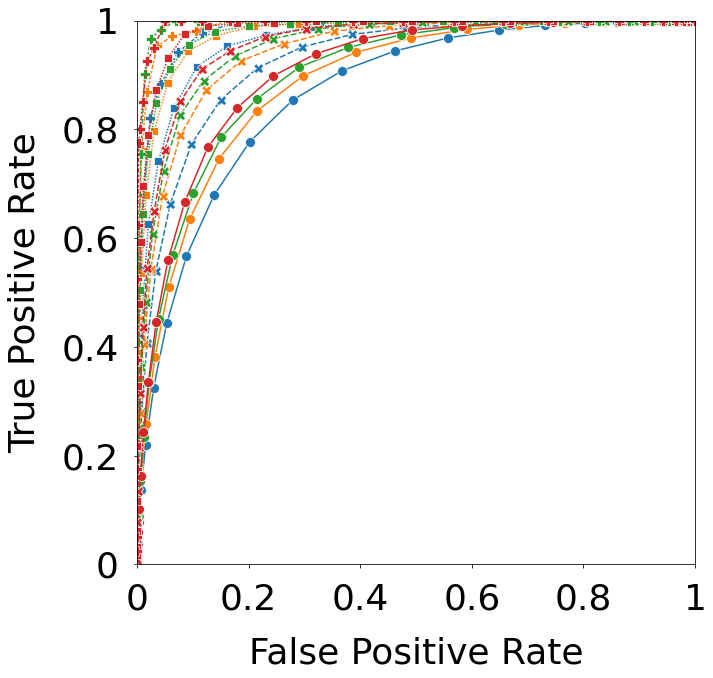

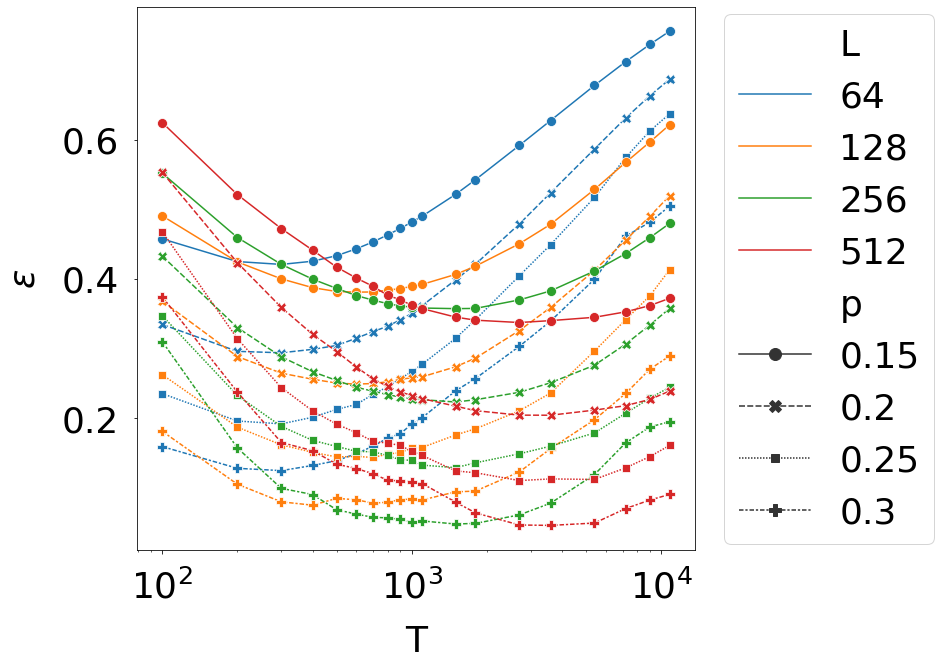

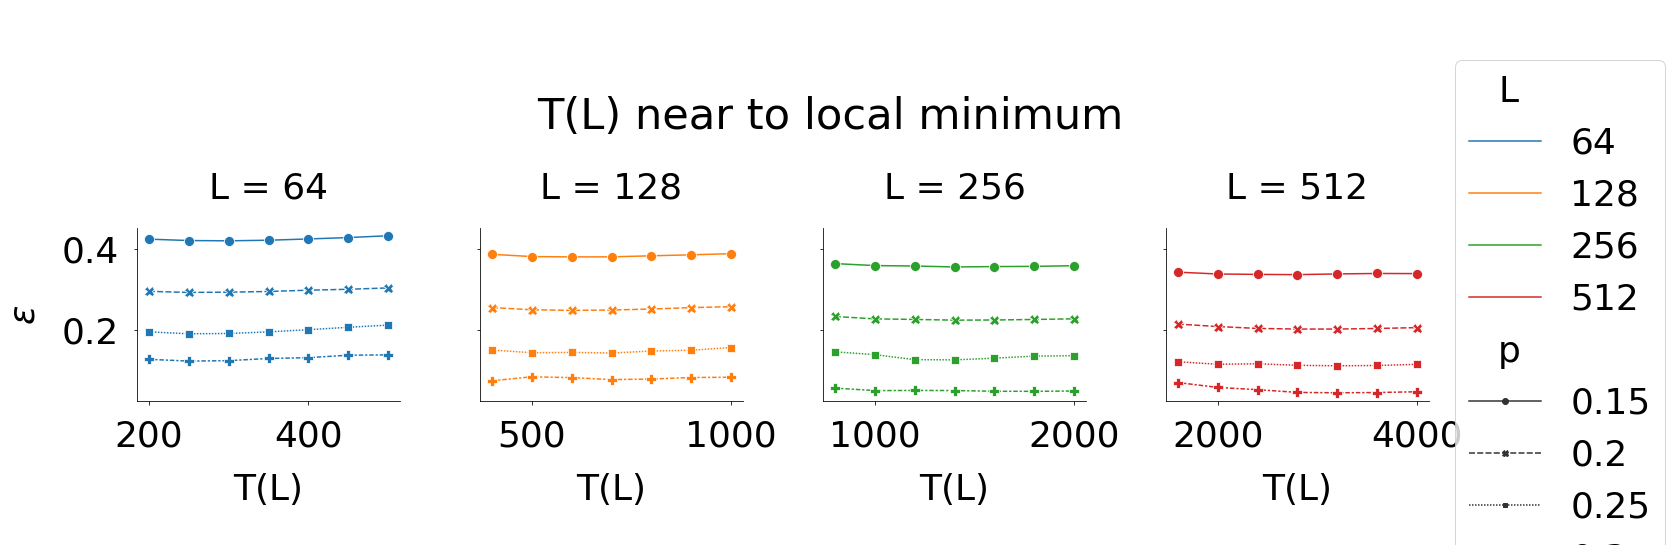

In [18]:
gamma = 2.75

plot_local_global(gamma, t_scaling, LS, PERCENTS_ETA, TS_local, TS_global, "rand")

In [19]:
gamma = 2.66

local_aucs = []

for i, L in enumerate(LS):
    TS_local_scaled = [int(t_scaling**i * t) for t in TS_local]
    auc_curve = calculate_roc_curve_gamma(gamma, PERCENTS_ETA, [L], TS_local_scaled, "rand", njobs=7)
    local_aucs.append(auc_curve)

local_auc_curves = pd.concat(local_aucs)

local_auc_curves = local_auc_curves.reset_index()
local_auc_curves.loc[list(local_auc_curves.groupby(["L", "model", "p"])["eps"].idxmin())]

,index,L,ETA,A,model,results,eps,fpr,tpr,T,p,gamma
20,20,64,9561,0.997780,rand,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.50113,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",450,0.15,2.66
21,21,64,12748,0.997780,rand,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.37378,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",450,0.20,2.66
26,26,64,15935,0.998002,rand,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.29760,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",500,0.25,2.66
27,27,64,19123,0.998002,rand,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.15478,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",500,0.30,2.66
52,24,128,60432,0.999000,rand,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.55697,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9e-05, 9e-05, 9...",1000,0.15,2.66
53,25,128,80576,0.999000,rand,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.44981,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1000,0.20,2.66
50,22,128,100720,0.998890,rand,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.36005,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",900,0.25,2.66
55,27,128,120864,0.999000,rand,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.24746,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1000,0.30,2.66
80,24,256,381952,0.999500,rand,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1e-0...",0.62965,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1e-05...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2000,0.15,2.66
81,25,256,509270,0.999500,rand,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1e-0...",0.52037,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1e-05...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2000,0.20,2.66


## Best T(L) by fixed $L$ and $p$

In [20]:
gamma = 2.68

roc_curve = calculate_roc_curve_gamma(gamma, PERCENTS_ETA, LS, TS, "rand", njobs=7)
roc_curve.loc[roc_curve.groupby(["L", "model", "p"])["eps"].idxmin()]

,L,ETA,A,model,results,eps,fpr,tpr,T,p,gamma
8,64,10390,0.996672,rand,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1e-05, 1e-05, ...",0.52942,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1e-05, 1e-05, 1...","[3e-05, 4e-05, 5e-05, 8e-05, 0.00012, 0.00017,...",300,0.15,2.68
9,64,13854,0.996672,rand,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1e-05, 1e-05, ...",0.42195,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1e-05, 1e-05, 1...","[5e-05, 8e-05, 0.00011, 0.00019, 0.0003, 0.000...",300,0.20,2.68
10,64,17318,0.996672,rand,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1e-05, 1e-05, ...",0.32457,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1e-05, 1e-05, 1...","[0.00016, 0.00023, 0.00031, 0.00055, 0.00078, ...",300,0.25,2.68
11,64,20781,0.996672,rand,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1e-05, 1e-05, ...",0.24022,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1e-05, 1e-05, 1...","[0.00052, 0.00078, 0.00104, 0.00181, 0.00259, ...",300,0.30,2.68
96,128,66590,0.998335,rand,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1e-05, 1e...",0.51595,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1e-05, 1e-...","[2e-05, 2e-05, 2e-05, 3e-05, 8e-05, 0.0001, 0....",600,0.15,2.68
93,128,88787,0.998002,rand,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1e-05, 1e...",0.40274,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1e-05, 1e-...","[4e-05, 4e-05, 4e-05, 4e-05, 8e-05, 0.00024, 0...",500,0.20,2.68
98,128,110984,0.998335,rand,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1e-05, 1e...",0.30700,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1e-05, 1e-...","[0.00011, 0.00011, 0.00011, 0.00022, 0.00054, ...",600,0.25,2.68
95,128,133181,0.998002,rand,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1e-05, 1e...",0.21289,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1e-05, 1e-...","[0.0, 0.0, 0.0, 0.0, 0.00034, 0.00101, 0.00168...",500,0.30,2.68
196,256,426750,0.999334,rand,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.51329,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2e-05, 2e-05, 2e-05, 2e-05, 2e-05, 5e-05, 7e-...",1500,0.15,2.68
205,256,569001,0.999630,rand,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.41167,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[6e-05, 6e-05, 0.00012, 0.00012, 0.00023, 0.00...",2700,0.20,2.68


We can see that the optimal scaling grater 2. Our assumtution is $T(L) = 2.25^{\log_{2}\frac{L}{64}} \cdot 300$.

### Statistics for optimal $\gamma$ and $T(L)$

Statistically prove that we have chosen the optimal parameters.

In [21]:
LS = [64, 128, 256, 512]
TS = [300, int(300 * 2.25), int(300 * 2.25**2), int(300*2.25**3)]
gammas = [2.6, 2.62, 2.63, 2.64, 2.65, 2.66, 2.67, 2.68, 2.7]
PERCENTS_ETA = [0.15, 0.2, 0.25, 0.30]

args = []
add_t = []
add_p = []
add_gamma = []

for percent in PERCENTS_ETA:
    for gamma in gammas:
        for T, L in zip(TS, LS):
            ETA = int(L**gamma * percent)
            A = np.exp(-1. / T)
            args.append((L, ETA, A, "rand"))
            add_t.append(T)
            add_p.append(percent)
            add_gamma.append(gamma)

abel_heap.calculate_conditional_probability_parallel(args, K_BINS=200, use_cache=True, njobs=7)
auc_curve = abel_heap.calculate_roc_curve_parallel(args, K_BINS=200, use_cache=True, njobs=7)

auc_curve["p"] = add_p
auc_curve["T"] = add_t
auc_curve["gamma"] = add_gamma
auc_curve["fpr"] = auc_curve["results"].apply(lambda x: list(x[0]))
auc_curve["tpr"] = auc_curve["results"].apply(lambda x: list(x[1]))
auc_curve["eps"] = auc_curve["results"].apply(lambda x: np.min(x[0] + (1 - x[1]))) # fpr + (1 - tpr)

In [22]:
#var = auc_curve.groupby(["p", "gamma"])["eps"].var().groupby("gamma").mean().rename("var")
var = auc_curve.groupby(["p", "gamma"])["eps"].var().rename("var").reset_index()

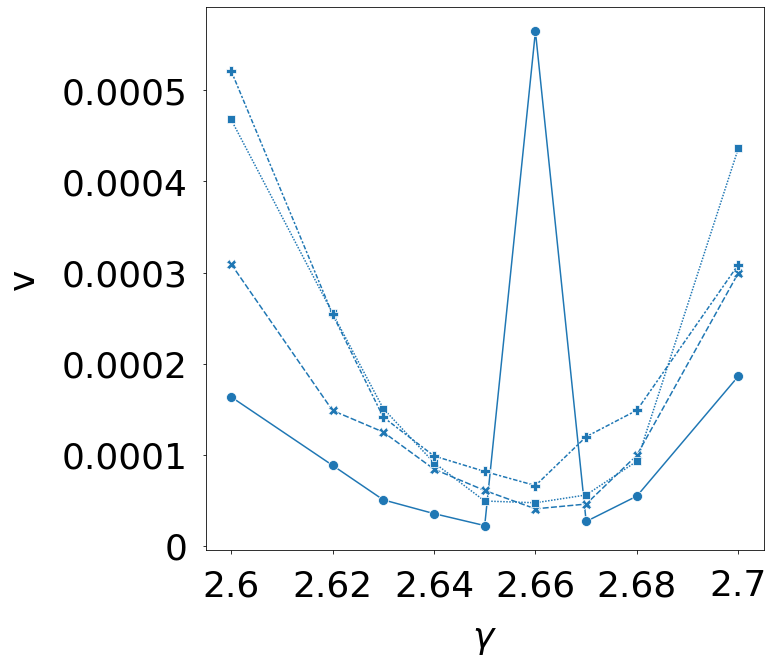

In [23]:
sns.lineplot(data=var, x="gamma", y="var", style="p", markers=True, palette="tab10", markersize=10, legend=False)
plt.ylabel("v")
plt.xticks([2.60, 2.62, 2.64, 2.66, 2.68, 2.70], [2.60, 2.62, 2.64, 2.66, 2.68, 2.70])
plt.yticks([0, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005], [0, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005])
plt.xlabel("$\gamma$")
plt.show()

In [24]:
from sklearn.linear_model import LinearRegression
from collections import defaultdict

gamma2coef = defaultdict(list)
absolute_coef = defaultdict(list)

for k, v in auc_curve.groupby(["gamma", "p"]):
    linreg = LinearRegression()
    y = v["eps"]
    X = np.array(v["T"]).reshape(y.shape[0], 1)
    linreg = linreg.fit(X, y)
    
    gamma2coef[k[0]].append(linreg.coef_[0])
    
    absolute_coef["gamma"].append(k[0])
    absolute_coef["p"].append(k[1])
    absolute_coef["absolute_coef"].append(np.abs(linreg.coef_[0]))
    
absolute_coef = pd.DataFrame(data=absolute_coef)

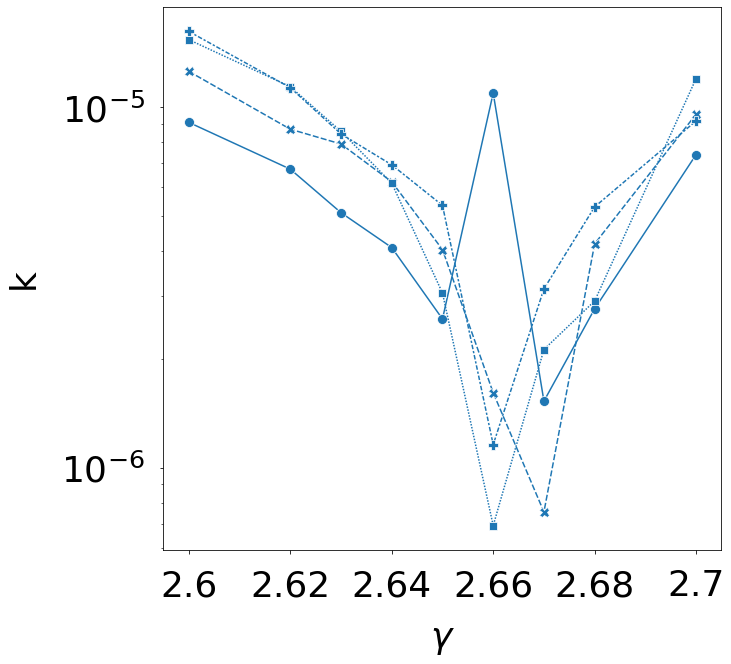

In [25]:
sns.lineplot(data=absolute_coef, x="gamma", y="absolute_coef", style="p", markers=True, palette="tab10", markersize=10, legend=False)
plt.ylabel("k")
plt.yscale("log")
plt.xticks([2.60, 2.62, 2.64, 2.66, 2.68, 2.70], [2.60, 2.62, 2.64, 2.66, 2.68, 2.70])
plt.xlabel("$\gamma$")
plt.show()

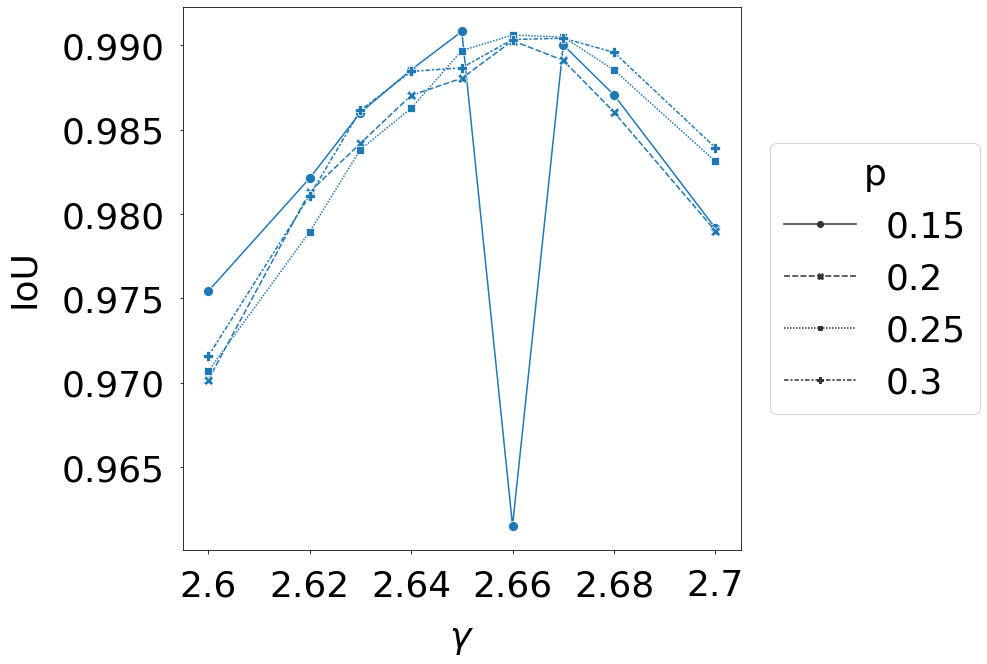

In [28]:
IoU = calculate_IoU(auc_curve)
sns.lineplot(data=IoU, x="gamma", y="IoU", style="p", markers=True, palette="tab10", markersize=10)
plt.xticks([2.60, 2.62, 2.64, 2.66, 2.68, 2.70], [2.60, 2.62, 2.64, 2.66, 2.68, 2.70])
plt.legend(bbox_to_anchor=[1.02, 0.5], loc='center left', title="p")
plt.xlabel("$\gamma$")
plt.show()

## Quality vs event rate

In [11]:
gamma = 2.75 # does not matter
PERCENTS_ETA_EXTENDED = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]
LS = [64, 128, 256, 512]
TS = [300, int(300 * 2.25), int(300 * 2.25**2), int(300*2.25**3)]
roc_curve = calculate_roc_curve_gamma(gamma, PERCENTS_ETA_EXTENDED, LS, TS, "rand", njobs=7, grid=False)
opt_metric = roc_curve.copy().reset_index() # pd.DataFrame(roc_curve.groupby(["L", "model", "p", "ETA"])["eps"].min()).reset_index()
opt_metric["p"] = opt_metric["p"].astype(float)
event_rate = calculate_event_rate(gamma, PERCENTS_ETA_EXTENDED, LS, "rand")
opt_metric = pd.merge(opt_metric, event_rate, on=["L", "p", "model"], how="left")

In [11]:
opt_metric

,index,L,ETA,A,model,results,eps,fpr,tpr,T,p,gamma,event_rate
0,0,64,926,0.996672,rand,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1e-05, 1e-05, ...",0.90598,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1e-05, 1e-05, 1...","[0.0, 0.0, 0.0, 1e-05, 1e-05, 1e-05, 2e-05, 3e...",300,0.01,2.75,3.391302e-02
1,1,64,4634,0.996672,rand,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1e-05, 1e-05, ...",0.73808,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1e-05, 1e-05, 1...","[1e-05, 1e-05, 1e-05, 2e-05, 3e-05, 4e-05, 6e-...",300,0.05,2.75,8.617260e-03
2,2,64,9268,0.996672,rand,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1e-05, 1e-05, ...",0.56763,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1e-05, 1e-05, 1...","[2e-05, 3e-05, 4e-05, 6e-05, 9e-05, 0.00012, 0...",300,0.10,2.75,2.598680e-03
3,3,64,13902,0.996672,rand,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1e-05, 1e-05, ...",0.42056,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1e-05, 1e-05, 1...","[5e-05, 8e-05, 0.00011, 0.00019, 0.0003, 0.000...",300,0.15,2.75,7.322800e-04
4,4,64,18536,0.996672,rand,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1e-05, 1e-05, ...",0.29354,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1e-05, 1e-05, 1...","[0.00023, 0.00035, 0.00047, 0.00082, 0.00117, ...",300,0.20,2.75,1.713800e-04
5,5,64,23170,0.996672,rand,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1e-05, 1e-05, ...",0.19136,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1e-05, 1e-05, 1...","[0.00129, 0.00194, 0.00258, 0.00323, 0.00452, ...",300,0.25,2.75,3.108000e-05
6,6,64,27804,0.996672,rand,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1e-05, 1e-05, ...",0.12417,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1e-05, 1e-05, 1...","[0.00893, 0.01339, 0.01339, 0.01786, 0.02679, ...",300,0.30,2.75,4.500000e-06
7,7,64,32438,0.996672,rand,"([0.0, 0.0, 0.0, 0.0, 0.0, 1e-05, 1e-05, 1e-05...",0.04796,"[0.0, 0.0, 0.0, 0.0, 0.0, 1e-05, 1e-05, 1e-05,...","[0.06897, 0.10345, 0.10345, 0.10345, 0.10345, ...",300,0.35,2.75,5.800000e-07
8,8,128,6234,0.998520,rand,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.91439,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1e-05, 1e-05, 1...",675,0.01,2.75,1.952000e-02
9,9,128,31174,0.998520,rand,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.73878,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1e-05, 1e-05, 2e-05, 2e-05, 2e-05, ...",675,0.05,2.75,4.921780e-03


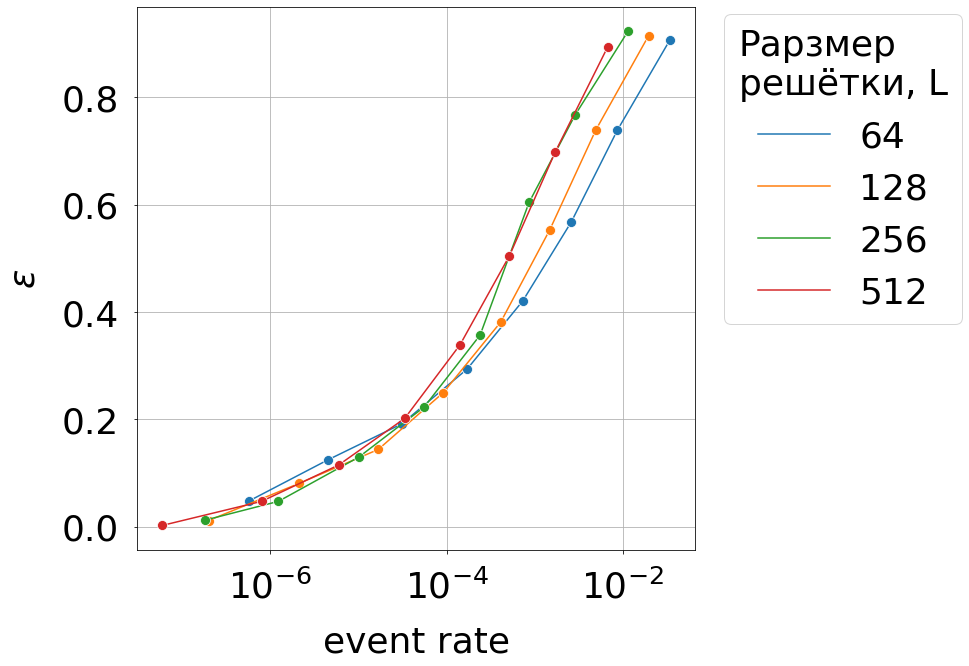

In [8]:
sns.lineplot(data=opt_metric, x="event_rate", y="eps", hue="L", marker="o", palette="tab10", markersize=10)

#plt.title(f"Quality of predictions depending on event rate in Manna model")
plt.xlabel("event rate")
plt.ylabel("$\epsilon$")
plt.xscale("log")
plt.grid()
#plt.yscale("log")
#plt.ylim([0, 1])
#plt.xlim([1e-7, 1e-1])
legend = plt.legend(bbox_to_anchor=(1.02,1.02), loc="upper left", markerscale=2)
legend.set_title("Рарзмер\nрешётки, L") 
plt.show()

In [29]:
opt_metric["normalized_s"].max()

0.5765136797087567

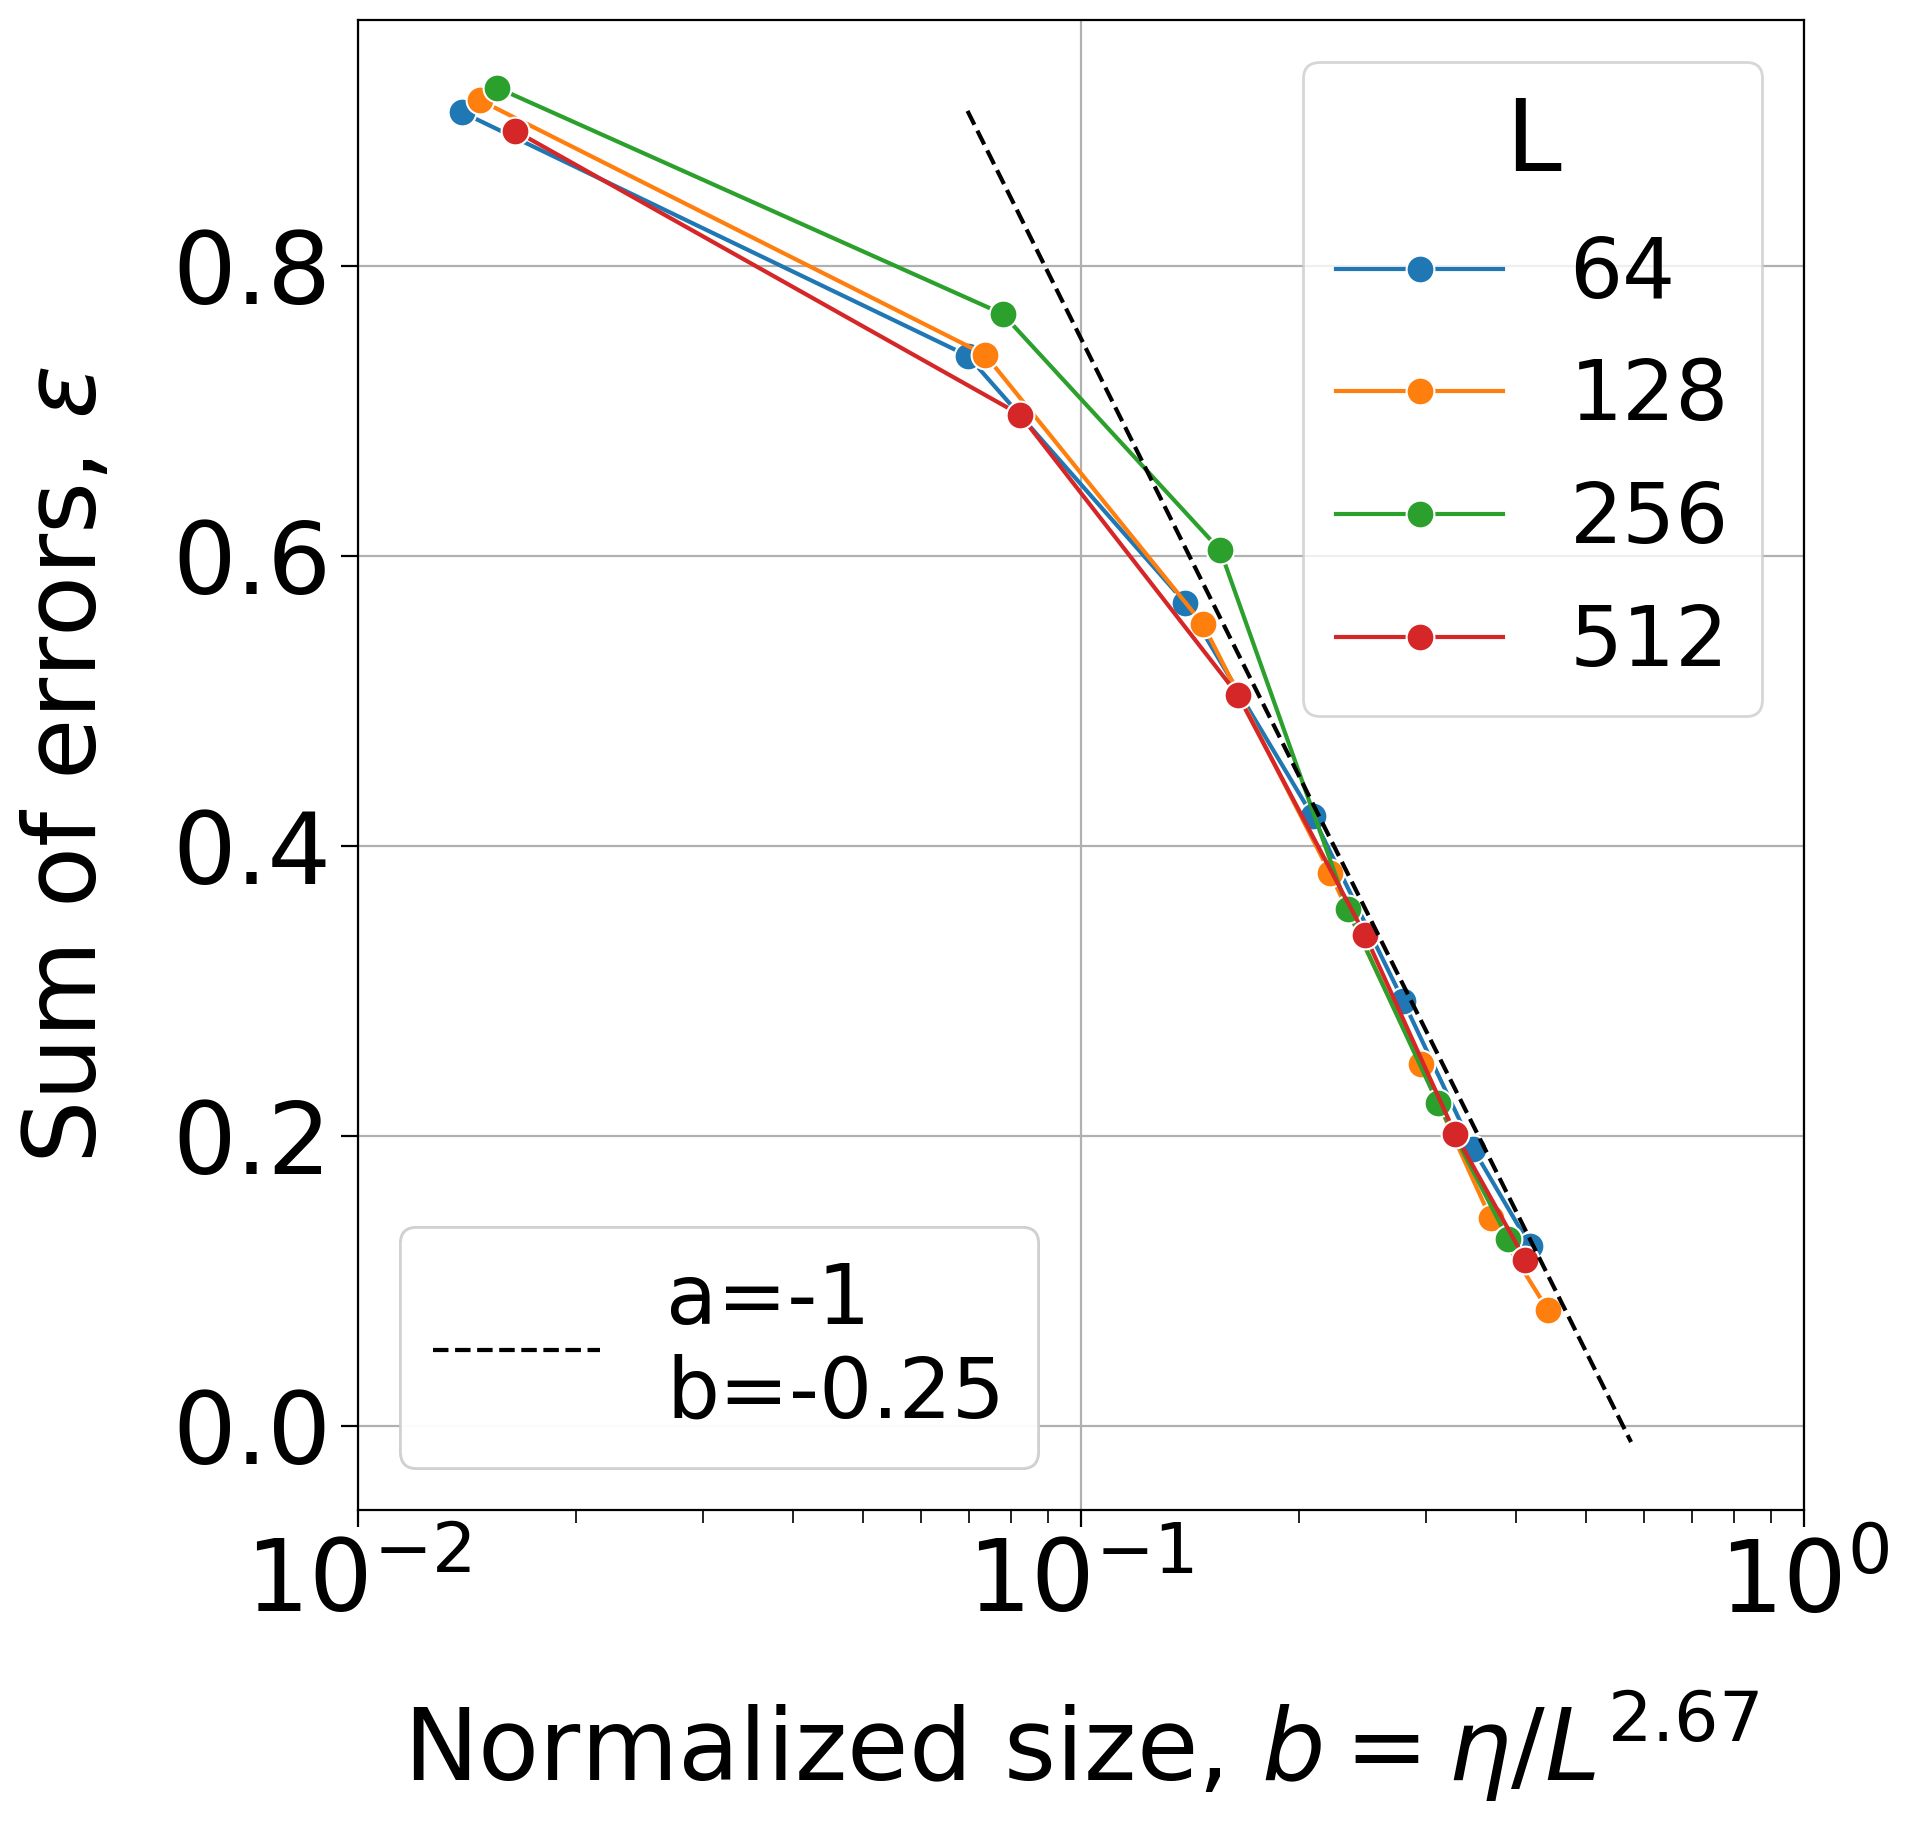

In [21]:
opt_metric["normalized_s"] = opt_metric["ETA"] / opt_metric["L"]**2.67
numer_of_events = opt_metric["event_rate"]*50_000_000

fig, ax = plt.subplots(1,1, figsize=(10, 10))

sns.lineplot(data=opt_metric[numer_of_events > 100], x="normalized_s", y="eps", hue="L", marker="o", palette="tab10", markersize=10, ax=ax)
plt.xlabel(r"Normalized size, $b = \eta / L^{2.67}$")
plt.ylabel("Sum of errors, $\epsilon$")
plt.xscale("log")
plt.grid()
#plt.ylim([0, 1])
#plt.xlim([1e-7, 1e-1])
#plt.ylim([0.3, 1])
#plt.xlim([1e-6, 1e-1])
#plt.axline(xy1=(0, k*0+b), xy2=(1, k*1+b))

a, b = -1, -0.25
x = [0.01393511176087724 * 5, 0.5765136797087567]
y = [a * np.log10(xi) + b for xi in x]
l1, = plt.plot(x, y, color="black", linestyle="--", label=f"a={a}\nb={b}")

# legend = plt.legend(bbox_to_anchor=(1.02,1.02), loc="upper left", markerscale=2)
# legend.set_title("L") 
# plt.show()

lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in [0,1,2,3]], ["64", "128", "256", "512"], loc=1, title="L", prop={'size': 30})
legend2 = plt.legend([l1], [f"a={a}\nb={b}"], loc=3, prop={'size': 30})
ax.add_artist(legend1)
ax.add_artist(legend2)

fig.tight_layout()
plt.tight_layout()

ax.set_xticks([0.01, 0.1, 1])

#ax.get_xaxis().get_major_formatter().labelOnlyBase = False
#ax.get_xaxis().set_tick_params(which='minor', size=0)
#ax.get_xaxis().set_tick_params(which='minor', width=0) 
plt.show()


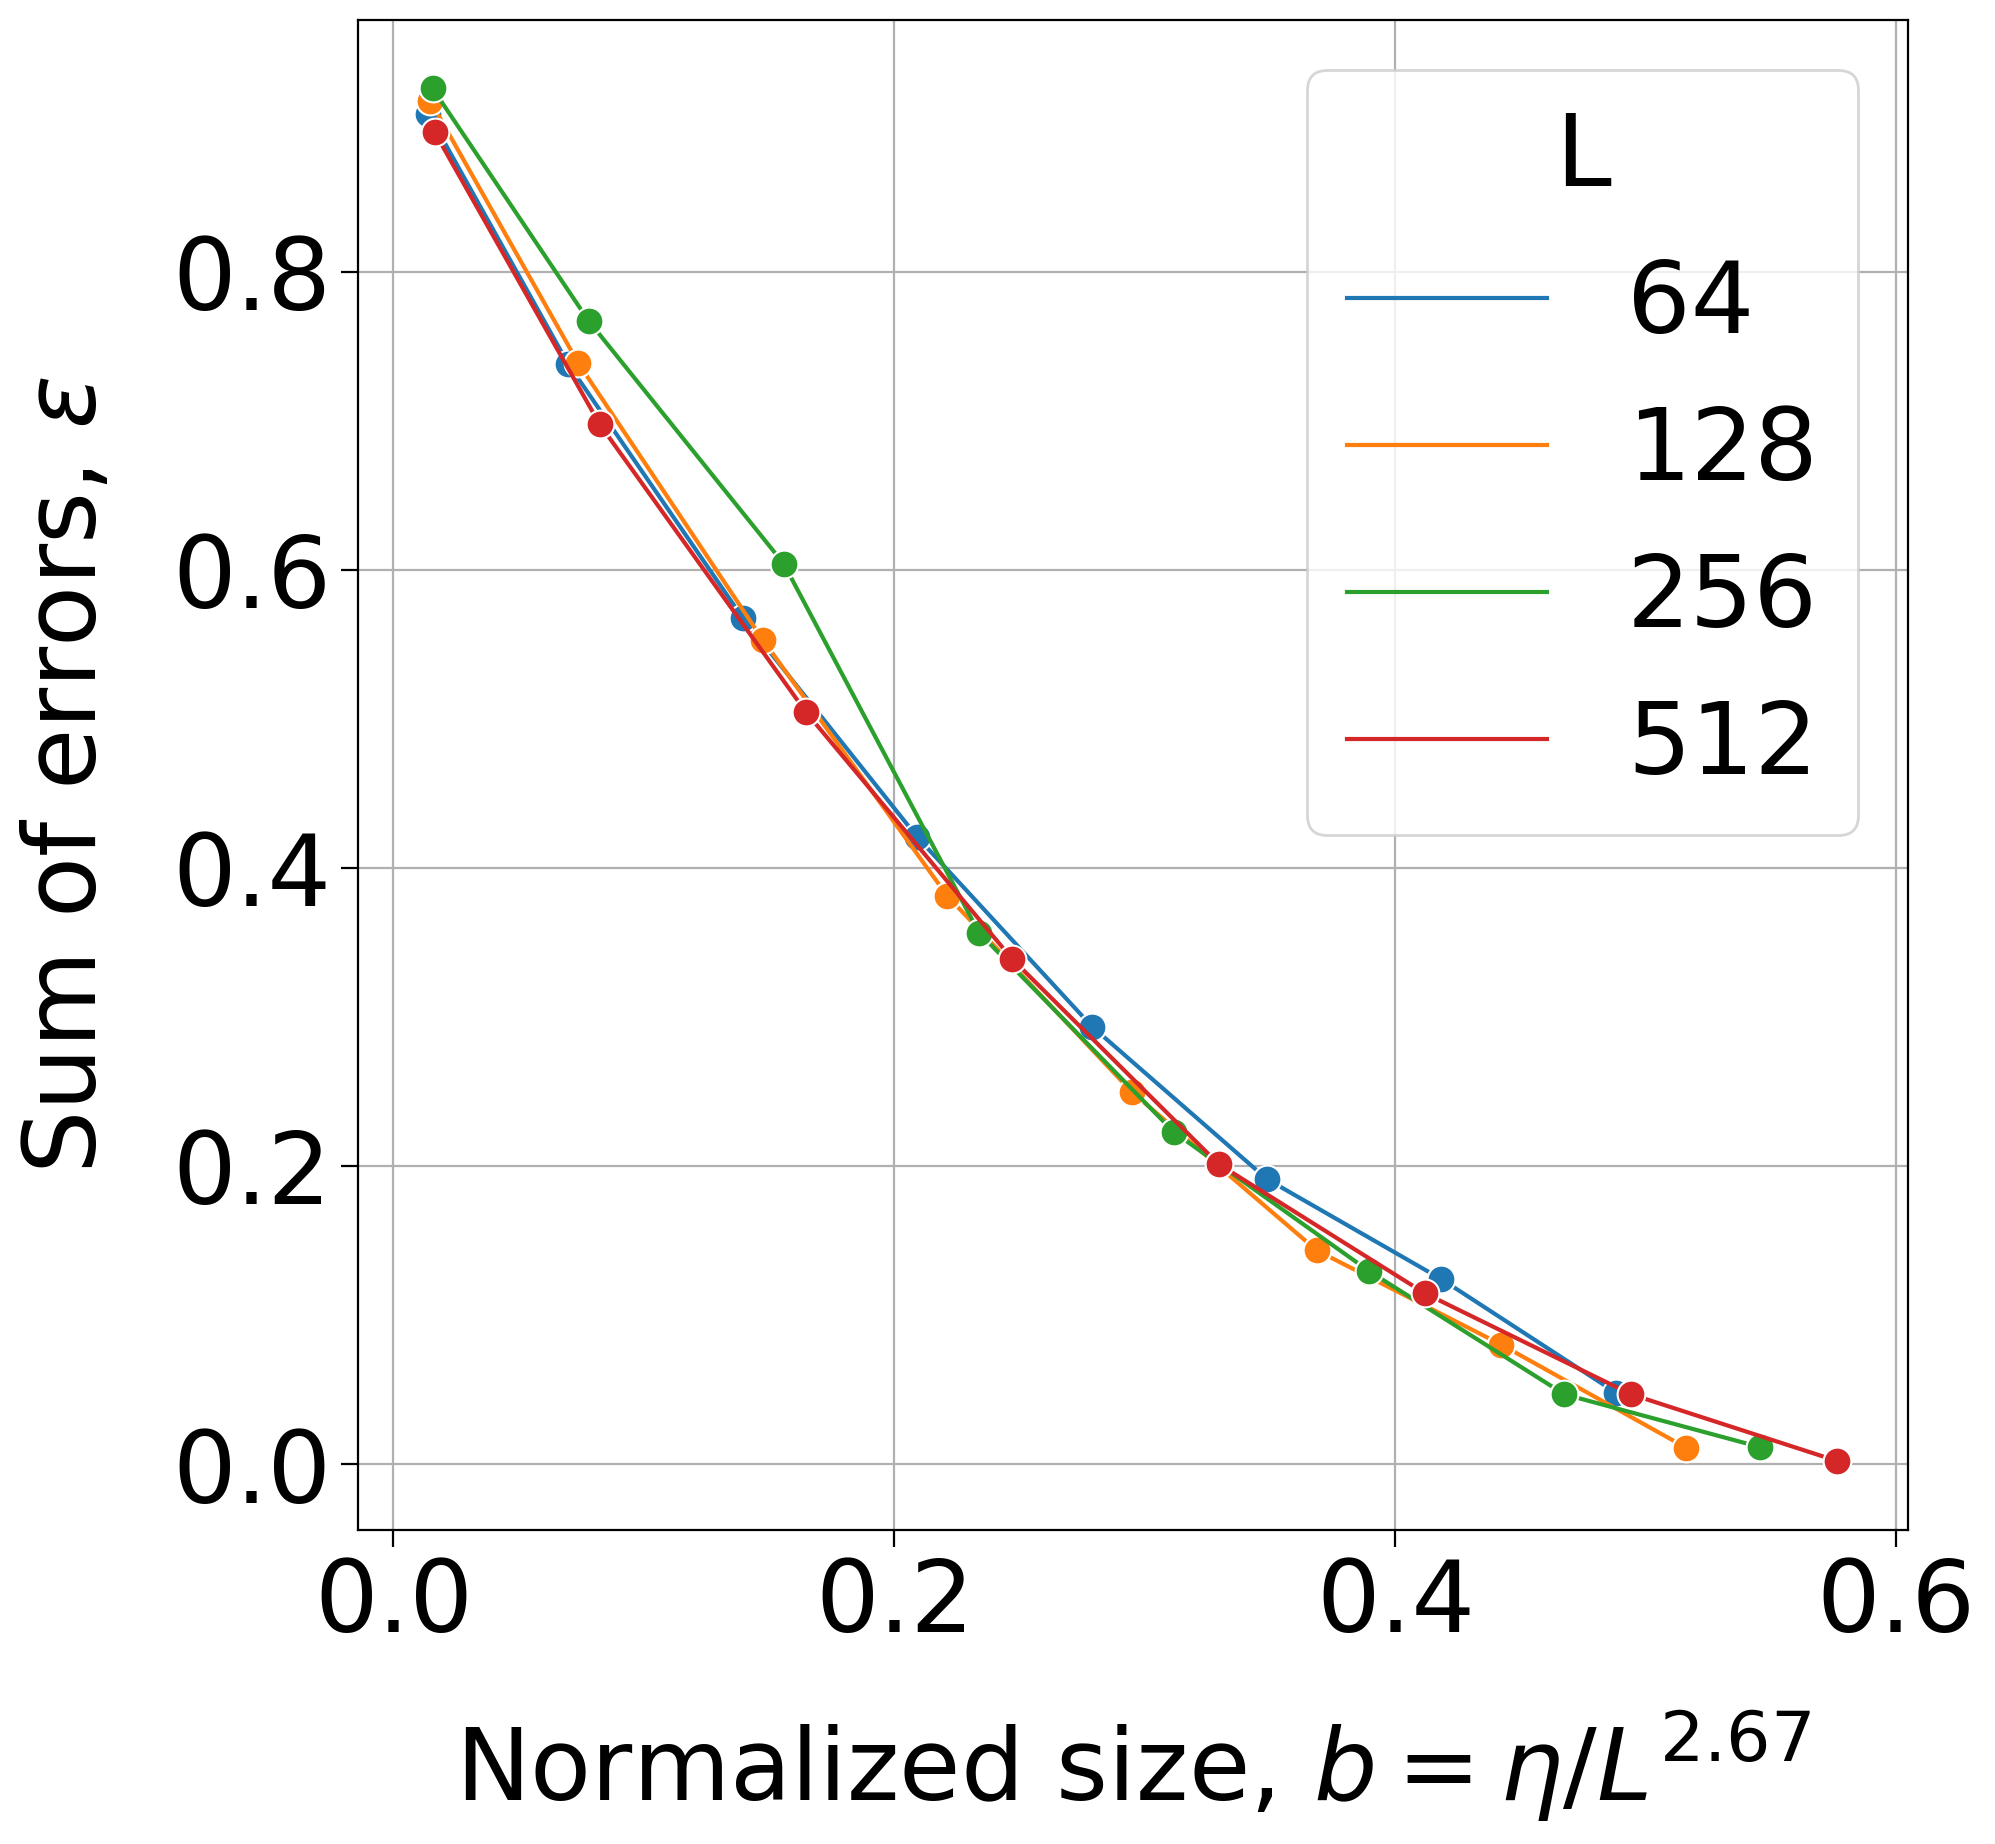

In [20]:
opt_metric["normalized_s"] = opt_metric["ETA"] / opt_metric["L"]**2.67

sns.lineplot(data=opt_metric, x="normalized_s", y="eps", hue="L", marker="o", palette="tab10", markersize=10)
plt.xlabel(r"Normalized size, $b = \eta / L^{2.67}$")
plt.ylabel("Sum of errors, $\epsilon$")
plt.grid()
#plt.yscale("log")
#plt.ylim([0, 1])
#plt.xlim([1e-7, 1e-1])
#plt.ylim([0.3, 1])
#plt.xlim([1e-6, 1e-1])
legend = plt.legend(loc=1, markerscale=2)
legend.set_title("L") 
plt.show()